## Constructing Conceptual Features

In [1]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
import numpy as np

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# Load language model and initialize matcher
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(vocab=nlp.vocab)

### Accessing data

In [4]:
reflections = pd.read_csv('../reflections.csv', encoding='utf_8', index_col='text_id')
reflections.head(1)

,student_id,submit_date,exam_date,exam_failed,text,attribution
text_id,,,,,,
201,X41usKKN,4/22/18 19:11,10/17/17,Non-Clinical: FPD OSCE (C-FPD),I retook this and passed. I hadn't reviewed the material well enough and went through the questions more closely when answering.,3


In [5]:
# Attribution is the human label of students' failure attribution (outcome of interest for training classifier)
# 1 = external or no attribution, 2 = internal, 3 = internal, explicitly controllable
# Checking class distribution
reflections['attribution'].value_counts()

attribution
2    475
3    277
1    243
Name: count, dtype: int64

In [6]:
# Checking dimensions: (# of rows, # of columns)
reflections.shape

(995, 6)

In [7]:
# More info about each column (missing values if any, data types)
reflections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 201 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   student_id   995 non-null    object
 1   submit_date  995 non-null    object
 2   exam_date    995 non-null    object
 3   exam_failed  995 non-null    object
 4   text         994 non-null    object
 5   attribution  995 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 54.4+ KB


### Preprocessing data

In [8]:
# Lower case reflection texts
reflections['text'] = reflections['text'].str.lower()
reflections.head(1)

,student_id,submit_date,exam_date,exam_failed,text,attribution
text_id,,,,,,
201,X41usKKN,4/22/18 19:11,10/17/17,Non-Clinical: FPD OSCE (C-FPD),i retook this and passed. i hadn't reviewed the material well enough and went through the questions more closely when answering.,3


### Extracting phrases

#### Noun phrases

In [9]:
noun_phrases = [] # A list to hold extracted noun phrases
    
for row in reflections.itertuples():
    text = str(row.text)
    # Processing text using spaCy's language model
    doc = nlp(text)
    # Use spaCy's noun chunks detector for obtaining noun phrases
    for chunk in doc.noun_chunks:
        # As ChatGPT cannot handle an extensive list of phrases due to restrictions on the number of words in a prompt, 
        # we ignore the noun phrases that only contain one stop word (e.g., “I”, “one”)
        # since these do not carry essential semantic information
        if len(chunk)==1 and chunk[0].is_stop:
            continue
        # Lemmatize the phrases and remove determiners in noun phrases to condensed the list of unique phrases
        # e.g., "a exam" and "the exams" will become one entry "exam"
        lemmatized = " ".join([t.lemma_ for t in chunk if t.pos_ not in ['DET']])
        # Append to holder list
        noun_phrases.append(lemmatized)

In [10]:
pd.Series(noun_phrases).value_counts()

exam                      276
question                  125
patient                    69
competency                 69
material                   56
                         ... 
hard tissue competency      1
induration                  1
masse                       1
dorsal tongue               1
proper identification       1
Name: count, Length: 1719, dtype: int64

In [11]:
# Obtain all noun phrases as input for Chat GPT
# print("\n".join(pd.Series(noun_phrases).value_counts().index))

#### Verb phrases

In [12]:
verb_phrases = [] # A list to hold extracted verb phrases

# Prior qualitative analyses show that perceived reasons for failure 
# are often expressed in the following forms of verb phrases

# Negation + verb (e.g., “not review”, “not identify”)
neg_verb = [{'DEP':'neg'},{'POS':'VERB'}]
# Verb prefixed or suffixed by an adverb (e.g., “[in]correctly identify”, “study hard”)
adv_verb = [{'POS':'ADV'},{'POS':'VERB'}]
verb_adv = [{'POS':'VERB'},{'POS':'ADV'}]
# Verb + open clausal complement (e.g., “fail to identify”)
verb_xcomp = [{'POS':'VERB'},{'IS_ALPHA':True,'OP':'{,3}'},{'DEP':'xcomp'}]
# Adjectival complement + preposition/auxiliary (e.g.,“[be] familiar with”, “[be] able to”)
adj_comp = [{'DEP':'acomp'},{'DEP':{'IN':['prep','aux']}}]
# Verbs start with “mis” that commonly describe a mistake (e.g., “misdiagnose”)
mis_verb = [{'POS':'VERB','TEXT': {'REGEX': 'mis[a-z]*'}}]

extractor = Matcher(vocab=nlp.vocab)
extractor.add('neg_verb', patterns=[neg_verb], greedy='LONGEST')
extractor.add('adv_verb', patterns=[adv_verb], greedy='LONGEST')
extractor.add('verb_adv', patterns=[verb_adv], greedy='LONGEST')
extractor.add('verb_xcomp', patterns=[verb_xcomp], greedy='FIRST') # greedy='FIRST' b/c we only want verb and xcomp close to each other
extractor.add('adj_comp', patterns=[adj_comp], greedy='LONGEST')
extractor.add('mis_verb', patterns=[mis_verb], greedy='LONGEST')

for row in reflections.itertuples():
    text = str(row.text)
    doc = nlp(text)
    # Extracting phrases (matching patterns) within each sentence
    for sent in doc.sents:
        results = extractor(sent,as_spans=True)
        for phrase in results:
            # Lemmatize the phrase to condense the list of unique phrases
            verb_phrases.append(" ".join([t.lemma_ for t in phrase]))

In [13]:
pd.Series(verb_phrases).value_counts()

able to                 68
not study               58
not know                54
miss                    52
unable to               44
                        ..
remember receive         1
clearly identify         1
clearly define           1
study enough to have     1
imperative to            1
Name: count, Length: 773, dtype: int64

In [14]:
# Obtain all "verb phrases" (not in strict linguistic sense) as input for Chat GPT
# print("\n".join(pd.Series(verb_phrases).value_counts().index))

### Finding linguistic patterns
#### A GenAI-assisted human-in-the-loop approach
To identify phrases associated with each perceived reason for fail- ure, we used ChatGPT 3.5 to group phrases related to the reasons described in Table 1. The prompts to ChatGPT take the general form of “From the list of phrases below, please find all phrases that can be used to describe [REASON]”. ChatGPT’s responses were then used to summarize linguistic patterns for detecting whether students mentioned a reason in their reflections (Table 3). When ChatGPT does not provide interpretable responses (e.g., generating a random cluster of phrases), we manually searched the phrase lists for keywords suggested in our coding scheme in prior qualitative analyses (e.g., searching for “material” for identifying phrases describing specific studying materials as re- viewing strategies).

We input noun phrases and verb phrases separately to ChatGPT because the size of combined list is too large for ChatGPT to handle (ChatGPT gave word restriction warning when it was provided with the combined list).

|   | Reasons                  | Noun Phrases                                                                       | Verb phrases                                                                       |
|---|--------------------------|------------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
|   | Exam                     | [Chat history](https://chat.openai.com/share/983f1c80-a5d0-4f10-a337-d934fb2be750) | [Chat history](https://chat.openai.com/share/75bc37ba-d727-47f5-8249-e90c727eaca5) |
|   | Course design            | [Chat history](https://chat.openai.com/share/53955c64-891b-4377-82f5-474e0d139b4f) | [Chat history](https://chat.openai.com/share/97c6997c-e15f-4bbe-9f73-1d4e5b8a3e17) |
|   | School activities        | [Chat history](https://chat.openai.com/share/a843591e-76f2-45cb-b88e-600c01cd6f24) | [Chat history](https://chat.openai.com/share/de307807-375d-472a-b0a3-b91fa29eefcb) |
|   | Efforts to prepare       | [Chat history](https://chat.openai.com/share/e7e906fe-c525-4734-96e1-c47407d2ca8a) | [Chat history](https://chat.openai.com/share/2528165e-9fd3-432f-a746-73be140953ba) |
|   | Learning/exam strategies | [Chat history](https://chat.openai.com/share/48098db9-09fe-42ce-91ec-5ffdf61dbe8b) | [Chat history](https://chat.openai.com/share/14b13e9b-f0bb-4d78-964a-c52308d065c0) |
|   | Mistakes during exam     | [Chat history](https://chat.openai.com/share/07fcf8ec-56da-43d8-838d-9df977ce3126) | [Chat history](https://chat.openai.com/share/beb2c70c-0f5e-44eb-a5c2-7de1498a2c0a) |
|   | Lack of knowledge        | [Chat history](https://chat.openai.com/share/83efa554-5dd1-45c4-ab5c-2de897a95bcf) | [Chat history](https://chat.openai.com/share/073f364b-8eda-49fb-9a46-2e6363c470e8) |
|   | Ability                  | [Chat history](https://chat.openai.com/share/82c16a50-e490-41e5-8772-a3d4678459a2) | [Chat history](https://chat.openai.com/share/3df8c0b7-097c-4a08-a923-02fb51bb136f) |
|   | Luck                     | [Chat history](https://chat.openai.com/share/0135da8c-3bef-47f4-9668-9407b7c3f31b) | [Chat history](https://chat.openai.com/share/4c5a6d67-9b25-414b-ad71-63e994114e64) |

The linguistic patterns identified are summarized in the table below:
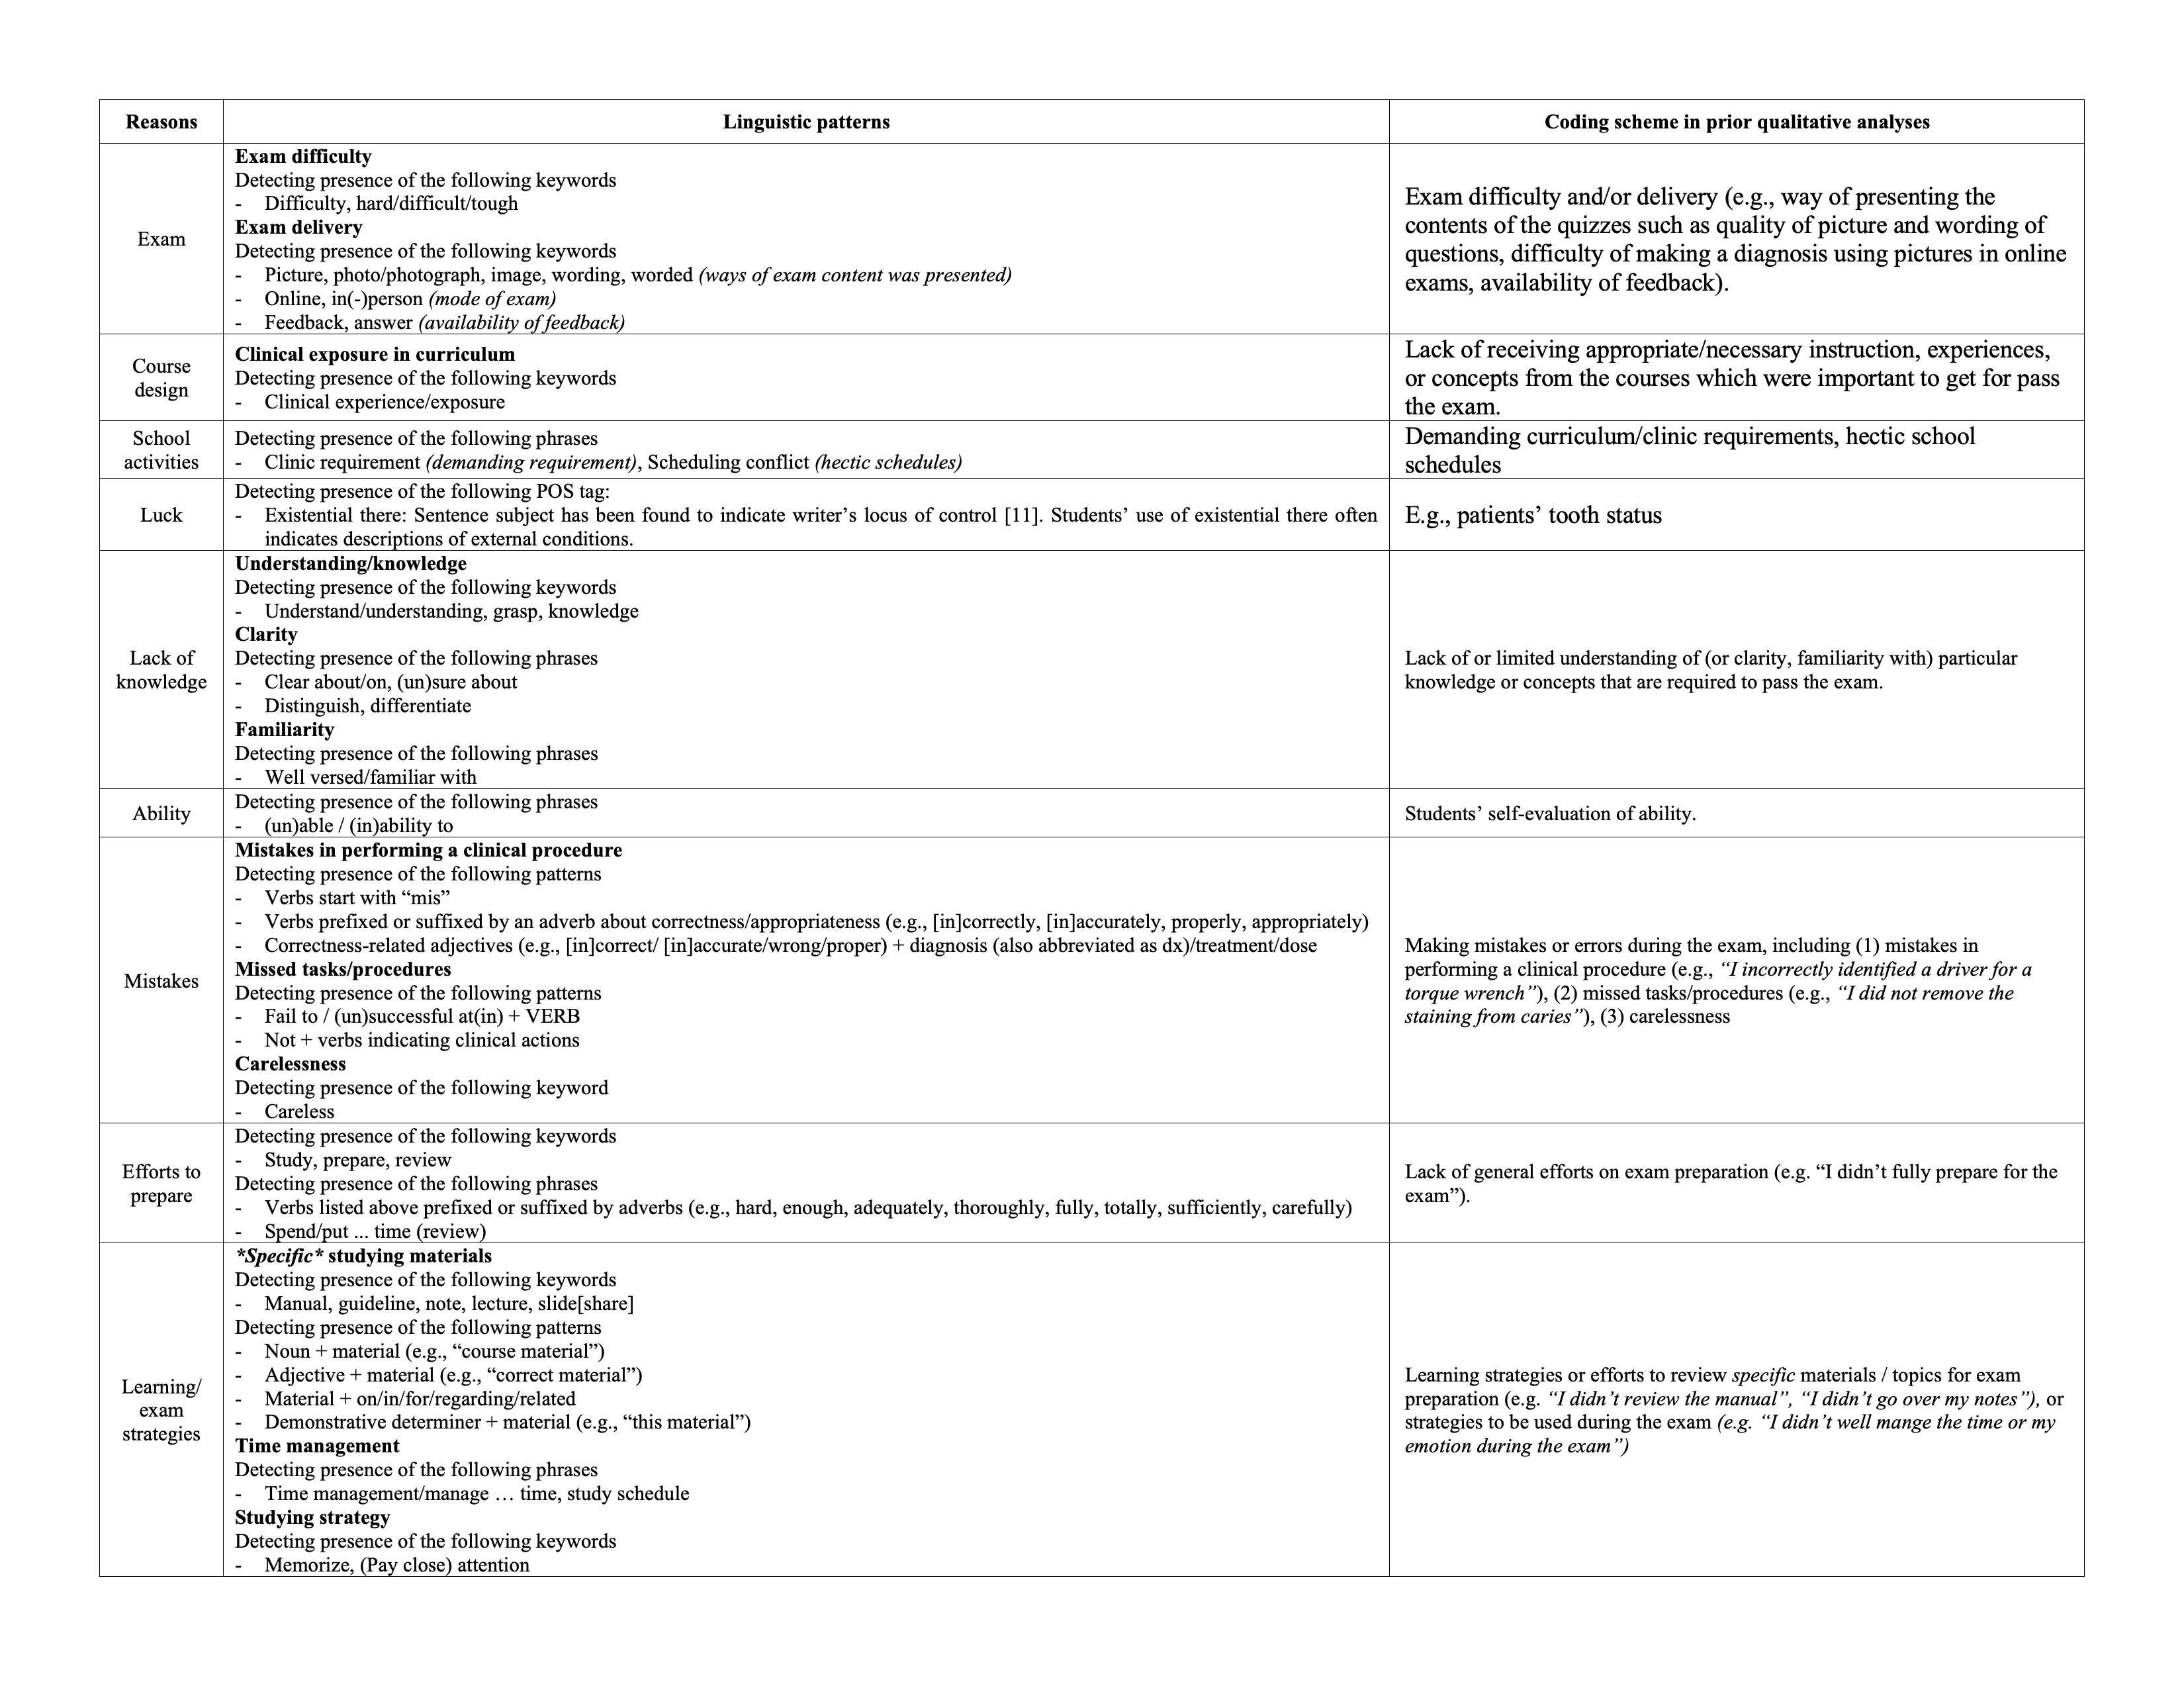

#### Creating Conceptual Features using Spacy Matcher

In [15]:
# Creating new columns for each conceptual features
reflections['exam'] = 0
reflections['course_design'] = 0
reflections['school_activities'] = 0
reflections['luck'] = 0
reflections['knowledge_gap'] = 0
reflections['ability'] = 0
reflections['mistake'] = 0
reflections['effort_prep'] = 0
reflections['strategy'] = 0
reflections['int_change'] = 0

In [16]:
# Constructing conceptual features via linguistic pattern matching

# ===== Defining patterns for each reason for failure (conceptual features) =====

# Exam
# Presence of difficulty, hard/difficult/tough
difficulty = [{'LEMMA':{'IN': ['tough','hard','difficult','difficulty']}}]
# Presence of picture, photo/photograph, image, wording, worded (ways of exam content was presented)
delivery_1 = [{'LEMMA':{'IN': ['picture','photo','photograph','image','online']}}]
delivery_2 = [{'TEXT':{'IN': ['wording','worded']}}]
# Presence of online, in(-)person (mode of exam)
delivery_3 = [{'TEXT':'in'},{'TEXT':'-','OP':'?'},{'TEXT':'person'}]
# Presence of feedback, answer (availability of feedback after exam)
delivery_4 = [{'POS':'NOUN','LEMMA':{'IN':['feedback','answer']}}]
# Add patterns to matcher
matcher.add('exam', patterns=[difficulty, delivery_1, delivery_2, delivery_3, delivery_4], greedy='LONGEST')

# Course design - Clinical exposure in curriculum
# Presence of clinical experience/exposure
curriculum = [{'LEMMA':'clinical'},{'LEMMA':{'IN': ['experience','exposure']}}]
# Add patterns to matcher
matcher.add('course_design', patterns=[curriculum], greedy='LONGEST')

# School activities
# Presence of clinic requirement (demanding curriculum requirement), scheduling conflict (hectic schedules)
clinic_requirement = [{'LEMMA':'clinic'},{'LEMMA':'requirement'}]
scheduling_conflict = [{'LEMMA':'scheduling'},{'LEMMA':'conflict'}]
# Add patterns to matcher
matcher.add('school_activities', patterns=[clinic_requirement, scheduling_conflict], greedy='LONGEST')

# Luck
# Presence of existential there
ex_there = [{'TAG':'EX'}]
# Add patterns to matcher
matcher.add('luck', patterns=[ex_there], greedy='LONGEST')

# Lack of knowledge
# Presence of understand/understanding, grasp, knowledge
understand = [{'LEMMA':{'REGEX': 'understand(ing)?'}}]
knowledge_grasp = [{'LEMMA':{'IN': ['knowledge','grasp']}}]
# Presence of clear about/on, (un)sure about, distinguish, differentiate (clarity)
clarity_1 = [{'LEMMA': {'IN': ['clear','sure','unsure']}},
             {'LEMMA': {'IN': ['about','on']}}]
clarity_2 = [{'LEMMA': {'IN': ['distinguish','differentiate']}}]
# Presence of well versed/familiar with (familarity)
familarity_1 = [{'TEXT':'well'},{'TEXT':'versed'}]
familarity_2 = [{'TEXT':'familiar'},{'TEXT':'with'}]
# Add patterns to matcher
matcher.add('knowledge_gap', patterns=[understand,knowledge_grasp,clarity_1,clarity_2,familarity_1,familarity_2], greedy='LONGEST')

# Ability
# Presence of (un)able / (in)ability to
ability = [{'LEMMA': {'IN': ['able','unable','ability','inability']}},
           {'LEMMA': 'to'}]
# Add patterns to matcher
matcher.add('ability', patterns=[ability], greedy='LONGEST')

# Mistakes
# Presence of verbs start with “mis”
mis_verb = [{'POS':'VERB','TEXT': {'REGEX': 'mis[a-z]*'}}]
# Presence of verbs prefixed or suffixed by an adverb about correctness/appropriateness 
correctness_ADV = ['incorrectly', 'correctly', 'inaccurately', 'accurately', 'properly', 'appropriately']
correct_adv_verb = [{'TEXT': {'IN': correctness_ADV}},{'POS':'VERB'}]
verb_correct_adv = [{'POS':'VERB'},{'IS_ALPHA':True,'OP':'{,5}'},{'TEXT': {'IN': correctness_ADV}}]
# Presence of correctness-related adjectives + diagnosis (also abbreviated as dx)/treatment/dose
mistake_np = [{'LEMMA': {'IN': ['incorrect','correct','wrong','proper']}},
              {'LEMMA': {'IN': ['diagnosis','dx','treatment','dose']}}]
# Presence of fail to / (un)successful at(in) 
failure_1 = [{'LEMMA':'fail'},{'LEMMA':'to'}]
failure_2 = [{'LEMMA':{'REGEX': '(un)?successful'}},{'LEMMA':{'IN':['at','in']}}]
# Presence of -	negation (not) + verbs indicating clinical actions 
# (clinical actions verbs were identified based on our contextual knowledge and ChatGPT's response
clinical_action = ['recognize','identify','detect','diagnose','palpate','remove','move','check','shine','cover','wear','brush','cut','prescribe','administer']
failure_3 = [{'LEMMA':'not'},{'POS':'VERB','LEMMA': {'IN': clinical_action}}]
# Presence of careless
careless = [{'LEMMA':'careless'}]
# Add patterns to matcher
matcher.add('mistake', patterns=[mis_verb,correct_adv_verb,verb_correct_adv,mistake_np,failure_1,failure_2,failure_3,careless], greedy='LONGEST')

# Efforts to prepare
# Presence of study, prepare, review
effort_1 = [{'LEMMA': {'IN': ['study','prepare','review']}}]
# Presence of study, prepare, review prefixed or suffixed by adverbs
effort_2 = [{'POS':'ADV'},{'LEMMA': {'IN': ['study','prepare','review']}}]
effort_3 = [{'LEMMA': {'IN': ['study','prepare','review']}},{'POS':'ADV'}]
# Presence of spend/put ... time
effort_4 = [{'LEMMA': {'IN': ['spend','put']}},{'IS_ALPHA':True,'OP':'*'},{'LEMMA':'time'}]
# Add patterns to matcher
matcher.add('effort_prep', patterns=[effort_1,effort_2,effort_3,effort_4], greedy='LONGEST')

# Strategies
# > *Specific* studying materials (reviewing strategy)
# Presence of manual, guideline, note, lecture, slide[share]
material_1 = [{'LEMMA':{'REGEX': '(manual|guideline|lecture|note|slide[\w]*)'}}]
# Presence of noun/adj + material (e.g., “course material”, e.g., “correct material”)
material_2 = [{'POS':{'IN': ['NOUN','ADJ']}},
              {'LEMMA':'material'}]
# Presence of material + on/in/for/regarding/related
material_3 = [{'LEMMA':'material'},
              {'TEXT':{'IN': ['on','in','for','regarding','related']}}]
# Presence of demonstrative determiner + material (e.g., “this material”)
material_4 = [{'MORPH':{'IS_SUPERSET': ['PronType=Dem']}},
              {'LEMMA':'material'}]
# > Time management
# Presence of time management/manage … time, study schedule
time_1 = [{'LEMMA': 'manage'},{'IS_ALPHA':True,'OP':'*'},{'LEMMA':'time'}]
time_2 = [{'LEMMA':'time'},{'LEMMA':'management'}]
time_3 = [{'LEMMA':'study'},{'LEMMA':'schedule'}]
# > Other studying strategy
# Presence of memorize, (Pay close) attention
strategy_1 = [{'LEMMA':'memorize'}]
strategy_2 = [{'LEMMA': 'pay'},{'IS_ALPHA':True,'OP':'*'},{'LEMMA':'attention'}]
# Add patterns to matcher
matcher.add('strategy', patterns=[material_1,material_2,material_3,material_4,time_1,time_2,time_3,strategy_1,strategy_2],greedy='LONGEST')

# Intention to Change
# Presence of “should/could have('ve)” to capture students’ use of intention-intensive language
int_chg_1 = [{'LEMMA':{'IN': ['should','could']}},{'LEMMA':{'IN': ['have',"'ve"]}}]
# Presence of “need to/more/further”, “will”, and comparatives (e.g., more, better) to capture 
# students’ use of future-focus language
int_chg_2 = [{'LEMMA':'need'},{'TEXT':{'IN': ['to','more','further']}}]
int_chg_3 = [{'TEXT':'will','TAG':'MD'}]
int_chg_4 = [{'MORPH':{'IS_SUPERSET': ['Degree=Cmp']}}]
# Add patterns to matcher
matcher.add('int_change', patterns=[int_chg_1,int_chg_2,int_chg_3,int_chg_4], greedy='LONGEST')

# ===== Extracting features using the patterns defined above =====

for row in reflections.itertuples():
    text = str(row.text)
    doc = nlp(text)
    # Matching patterns within each sentence
    for sent in doc.sents:
        results = matcher(sent,as_spans=True)
        # Iterating over the matched phrases
        for phrase in results:
            # Check name of matched pattern
            matched_pattern = nlp.vocab[phrase.label].text
            # Increment the corresponding features in the data frame
            if matched_pattern == "exam":
                reflections.at[row.Index,'exam'] += 1
            if matched_pattern == "course_design":
                reflections.at[row.Index,'course_design'] += 1
            if matched_pattern == "school_activities":
                reflections.at[row.Index,'school_activities'] += 1
            if matched_pattern == "luck":
                reflections.at[row.Index,'luck'] += 1
            if matched_pattern == "knowledge_gap":
                reflections.at[row.Index,'knowledge_gap'] += 1
            if matched_pattern == "ability":
                reflections.at[row.Index,'ability'] += 1
            if matched_pattern == "mistake":
                reflections.at[row.Index,'mistake'] += 1
            if matched_pattern == "effort_prep":
                reflections.at[row.Index,'effort_prep'] += 1
            if matched_pattern == "strategy":
                reflections.at[row.Index,'strategy'] += 1
            if matched_pattern == "int_change":
                reflections.at[row.Index,'int_change'] += 1
            

In [17]:
# Considering the sparseness of reasons describing external factors 
# (i.e., exam, course design, school activities, luck, cf. Table 1)
# we also combined these four features by computing their sum
reflections['external_factor'] = reflections['exam'] + reflections['course_design'] + reflections['school_activities'] + reflections['luck']
reflections.head()

,student_id,submit_date,exam_date,exam_failed,text,attribution,exam,course_design,school_activities,luck,knowledge_gap,ability,mistake,effort_prep,strategy,int_change,external_factor
text_id,,,,,,,,,,,,,,,,,
201,X41usKKN,4/22/18 19:11,10/17/17,Non-Clinical: FPD OSCE (C-FPD),i retook this and passed. i hadn't reviewed the material well enough and went through the questions more closely when answering.,3,0,0,0,0,0,0,0,1,0,1,0
202,VGUvRpjx,4/30/18 11:36,10/9/17,Non-Clinical: FPD OSCE (C-FPD),i was not brushed on on rpd and cd protocol. i needed to spend more time ont his.,3,0,0,0,0,0,0,1,1,0,2,0
203,X5Ap5y+5,4/11/18 12:22,11/14/17,Non-Clinical: FPD OSCE (C-FPD),"i have not been able to see feedback on this exam, so i do not know what error(s) i made.",1,1,0,0,0,0,1,0,0,0,0,1
204,U3kHzJLD,10/26/17 10:45,10/3/17,Non-Clinical: FPD OSCE (C-FPD),i did not sufficiently review the material on fixed prostheses,3,0,0,0,0,0,0,0,1,1,0,0
205,RJbC3WEI,2/14/18 21:11,10/31/17,Non-Clinical: FPD OSCE (C-FPD),"i didn't answer the questions correctly. i thought i had prepared enough for this competency, but it wasn't enough. some of the questions were more difficult than the others.",2,1,0,0,0,0,0,1,1,0,1,1


In [18]:
reflections.to_csv('conceptual_features.csv')